# Árbol de regresión Kilos Lana 2

## Librerías

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

## Datos

El set de datos son las variables de produccion y climaticas anuales. Se pretende ajustar un modelo de regresión que permita predecir la cantidad de Lana en función de las variables disponibles.

In [2]:
datos = pd.read_csv('datos_produccion_clima_35_1.csv', sep=",")
datos.head(3)

,fecha,esquila,ovejas,corderos,kilos_lana,rinde_seco,finura,kilo_lana_p/animal,porcentaje_paricion,temp_media,temp_min,tem_max,humedad,cant_lluvia,rad_solar,vel_viento
0,31/12/1985,3514,1419,912,15600,60.46,19.26,4.44,64.27,14.3,6.4,20.9,0.0,208.6,4312.72,6.1
1,31/12/1986,3783,1520,680,18167,61.52,19.86,4.80,44.74,12.9,5.8,20.5,58.1,130.3,4236.36,6.8
2,31/12/1987,3988,1928,512,11200,55.77,19.41,2.81,26.56,13.8,6.8,20.7,60.3,199.5,4142.41,6.4


In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fecha                36 non-null     object 
 1   esquila              36 non-null     int64  
 2   ovejas               36 non-null     int64  
 3   corderos             36 non-null     int64  
 4   kilos_lana           36 non-null     int64  
 5   rinde_seco           36 non-null     float64
 6   finura               36 non-null     float64
 7   kilo_lana_p/animal   36 non-null     float64
 8   porcentaje_paricion  36 non-null     float64
 9   temp_media           36 non-null     float64
 10  temp_min             36 non-null     float64
 11  tem_max              36 non-null     float64
 12  humedad              36 non-null     float64
 13  cant_lluvia          36 non-null     float64
 14  rad_solar            36 non-null     float64
 15  vel_viento           36 non-null     float

## Ajuste del modelo

La clase DecisionTreeRegressor del módulo sklearn.tree permite entrenar árboles de decisión para problemas de regresión. A continuación, se ajusta un árbol de regresión empleando como variable respuesta **kilos_lana** y como predictores todas las otras variables disponibles.

Como en todo estudio de regresión, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer la posterior evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.

In [4]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = ["kilos_lana", "fecha"]),
                                        datos['kilos_lana'],
                                        random_state = 123
                                    )

In [5]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeRegressor(
            max_depth         = 3,
            random_state      = 123
          )

In [6]:
# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=123)

Una vez entrenado el árbol, se puede representar mediante la combinación de las funciones plot_tree() y export_text(). La función plot_tree() dibuja la estructura del árbol y muestra el número de observaciones y valor medio de la variable respuesta en cada nodo. La función export_text() representa esta misma información en formato texto

Profundidad del árbol: 3
Número de nodos terminales: 8


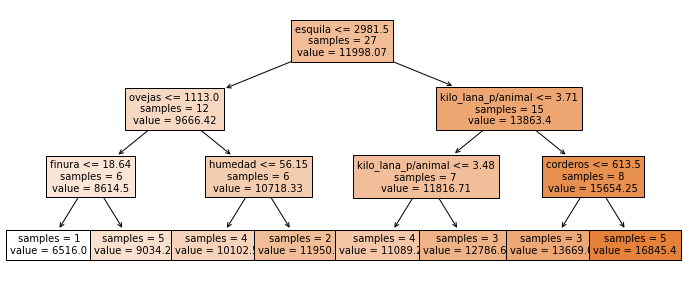

In [7]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = datos.drop(columns = ["kilos_lana","fecha"]).columns,
            class_names   = 'kilos_lana',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [8]:
texto_modelo = export_text(
                    decision_tree = modelo,
                    feature_names = list(datos.drop(columns = ["kilos_lana","fecha"]).columns)
               )
print(texto_modelo)

|--- esquila <= 2981.50
|   |--- ovejas <= 1113.00
|   |   |--- finura <= 18.64
|   |   |   |--- value: [6516.00]
|   |   |--- finura >  18.64
|   |   |   |--- value: [9034.20]
|   |--- ovejas >  1113.00
|   |   |--- humedad <= 56.15
|   |   |   |--- value: [10102.50]
|   |   |--- humedad >  56.15
|   |   |   |--- value: [11950.00]
|--- esquila >  2981.50
|   |--- kilo_lana_p/animal <= 3.71
|   |   |--- kilo_lana_p/animal <= 3.48
|   |   |   |--- value: [11089.25]
|   |   |--- kilo_lana_p/animal >  3.48
|   |   |   |--- value: [12786.67]
|   |--- kilo_lana_p/animal >  3.71
|   |   |--- corderos <= 613.50
|   |   |   |--- value: [13669.00]
|   |   |--- corderos >  613.50
|   |   |   |--- value: [16845.40]



Siguiendo la rama más a la izquierda del árbol, puede verse que el modelo predice un precio promedio de 9034 kilos de lana a partir de esquila <= 2981.50, ovejas <= 1113.00 y un finura <= 18.64.

## Importancia de predictores

La importancia de cada predictor en modelo se calcula como la reducción total (normalizada) en el criterio de división, en este caso el mse, que consigue el predictor en las divisiones en las que participa. Si un predictor no ha sido seleccionado en ninguna divisón, no se ha incluido en el modelo y por lo tanto su importancia es 0.

In [9]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = ["kilos_lana","fecha"]).columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,esquila,0.535282
5,kilo_lana_p/animal,0.273126
2,corderos,0.086233
1,ovejas,0.060526
4,finura,0.024088
10,humedad,0.020745
3,rinde_seco,0.000000
6,porcentaje_paricion,0.000000
7,temp_media,0.000000
8,temp_min,0.000000


El predictor esquila, el número de animales esquilados, ha resultado ser el predictor más importante en el modelo, seguido de kilo_lana_p/animal, que mide la cantidad de kilo de lana por animal.

## Podado del árbol (pruning)

Con la finalidad de reducir la varianza del modelo y así mejorar la capacidad predictiva, se somete al árbol a un proceso de pruning. Para aplicar el proceso de pruning es necesario indicar el argumento ccp_alpha que determina el grado de penalización por complejidad. Cuanto mayor es este valor, más agresivo el podado y menor el tamaño del árbol resultante.

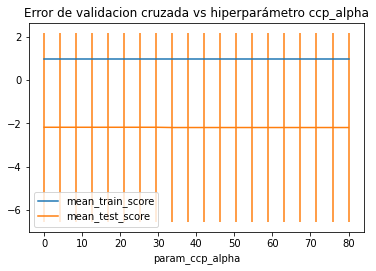

In [10]:
# Pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 80, 20)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible para luego aplicar el pruning
        estimator = DecisionTreeRegressor(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [11]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 4.2105263157894735}

Una vez identificado el valor óptimo de ccp_alpha, se reentrena el árbol indicando este valor en sus argumentos.

Profundidad del árbol: 6
Número de nodos terminales: 26


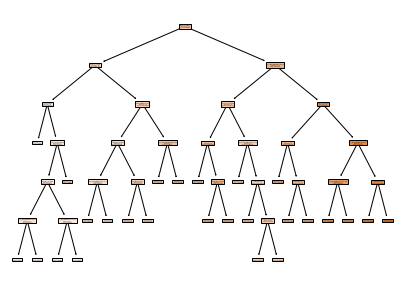

In [12]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(7, 5))
plot = plot_tree(
            decision_tree = modelo_final,
            feature_names = datos.drop(columns = ["kilos_lana","fecha"]).columns,
            class_names   = 'kilos_lana"',
            filled        = True,
            impurity      = False,
            ax            = ax
       )

El proceso de pruning a identificado como mejor árbol uno mucho más grande que el modelo inicialmente entrenado.

## Predicción y evaluación del modelo

Por último, se evalúa la capacidad predictiva del primer árbol y del árbol final empleando el conjunto de test.

In [13]:
# Error de test del modelo inicial
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3124.692335165887


In [14]:
# Error de test del modelo final (tras aplicar pruning)
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3417.9558543407525


El proceso de pruning consigue aumentar el error rmse del modelo de 3124.6 a 3417.95. Las predicciones del modelo final se alejan en promedio 3417.95 unidades del valor real (3417.95 kilos espero).